<hr/>

# imports

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [4]:
def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It 
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to 
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [5]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [6]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse
    
    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    return data

In [7]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, label_encoder = None) -> None:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        label_encoder:
            the label encoder used for the target labels
    """

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    print(f"{'='*10} Test Evaluation {'='*10}")
    test_loss, test_acc = model.evaluate(test_ds, test_target, verbose=2)
    print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
    print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)
    y_pred_labels = np.argmax(y_pred, axis=1)
    print(sklearn.metrics.classification_report(test_target, y_pred_labels, target_names=(label_encoder.classes_ if label_encoder != None else None)))

In [8]:
def Tokenize(tokenizer, df: pd.DataFrame, sequence_len = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return encoded_msg, keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), encoded_prev_msg, keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

<hr/>

# data explortion

In [9]:
train_df = pd.read_json("./data/train.jsonl", lines=True)
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1


just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

In [10]:
train_df = (parse_jsonl("./data/train.jsonl"))
test_df = (parse_jsonl("./data/test.jsonl"))
validation_df = (parse_jsonl("./data/validation.jsonl"))

In [11]:
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0,1,0,,straightforward
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0,1,0,👍,straightforward
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0,1,0,It seems like there are a lot of ways that cou...,straightforward


# NONANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value 

In [12]:
round(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index), 4) * 100

8.43

I think we can ignore this for now since the main columns i think we will be using are `messages` and `sender_labels`

If we do need it in the future, we can omit it only losing 8.43% of the rows.

# Unique Words

In [22]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 12
just: 1250
the: 6574
person: 29
i: 8947
want: 842
to: 11615
speak: 18
with.: 34
have: 2087
a: 4783
somewhat: 16
crazy: 16
idea: 97
that: 3692
i’ve: 153
always: 84
wanted: 146
try: 307
with: 2567
i/g,: 1
but: 2250
never: 109
actually: 208
convinced: 11
other: 285
guy: 30
it.: 263
and,: 38
what’s: 85
worse,: 3


In [13]:
len(unique_words)

15657

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

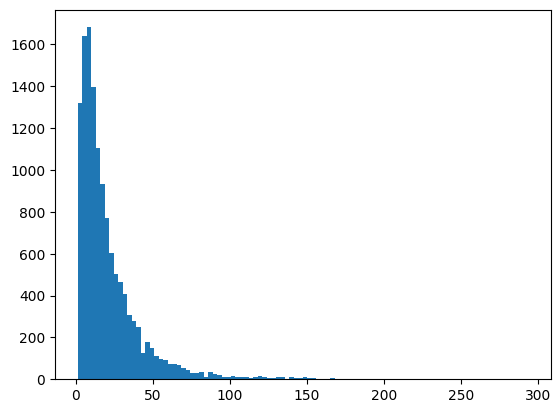

In [14]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [15]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,13132
1,Average words per message,20
2,Unique word count,15657
3,Actual Lie count,591
4,Actual Truth count,12541


# Label count

In [16]:
train_df['label'].value_counts()

label
straightforward    12040
deceive              526
cassandra            501
caught                65
Name: count, dtype: int64

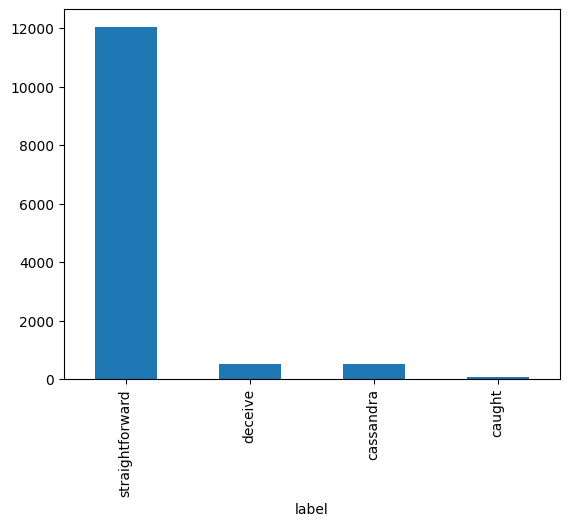

In [17]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [18]:
train_df['label'].value_counts(normalize=True)

label
straightforward    0.916844
deceive            0.040055
cassandra          0.038151
caught             0.004950
Name: proportion, dtype: float64

<hr/>

# Constants

In [19]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
label_encoder = sklearn.preprocessing.LabelEncoder()

train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.fit_transform(test_df['label'])
validation_df['label_encoded'] = label_encoder.fit_transform(validation_df['label'])

train_encoded, train_encoded_padded, train_prev_encoded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded, test_encoded_padded, test_prev_encoded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded, validation_encoded_padded, validation_prev_encoded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

<hr/>

# Naive Nueral Network

In [20]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = 64,
        sequence_length: int = MAX_SEQUENCE_LEN,
        learning_rate: float = 0.001
    ):

    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [21]:
naive_model = create_naive_model(embedding_output=128)
naive_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 294, 128)          640000    
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 4)                 150532    
                                                                 
Total params: 790532 (3.02 MB)
Trainable params: 790532 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 294, 128)          640000    
                                                                 
 flatten (Flatten)  

In [22]:
naive_history = naive_model.fit(
    train_encoded_padded,
    train_df['label_encoded'],
    validation_data=(validation_encoded_padded, validation_df['label_encoded']),
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 14s 33ms/step - loss: 0.3716 - accuracy: 0.9148 - val_loss: 0.3082 - val_accuracy: 0.9301
Epoch 2/10
411/411 [==============================] - 5s 11ms/step - loss: 0.2827 - accuracy: 0.9222 - val_loss: 0.3342 - val_accuracy: 0.9301
Epoch 3/10
411/411 [==============================] - 4s 9ms/step - loss: 0.1653 - accuracy: 0.9500 - val_loss: 0.3795 - val_accuracy: 0.9287
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 0.0954 - accuracy: 0.9737 - val_loss: 0.4258 - val_accuracy: 0.9251
Epoch 5/10
411/411 [==============================] - 2s 6ms/step - loss: 0.0617 - accuracy: 0.9845 - val_loss: 0.4987 - val_accuracy: 0.9280
Epoch 6/10
411/411 [==============================] - 2s 6ms/step - loss: 0.0435 - accuracy: 0.9899 - val_loss: 0.5268 - val_accuracy: 0.9237
Epoch 7/10
411/411 [==============================] - 3s 7ms/step - loss: 0.0338 - accuracy: 0.9917 - val_loss: 0.5737 - val_accuracy: 0.9244
Epo

========== Model Accuracy ==========


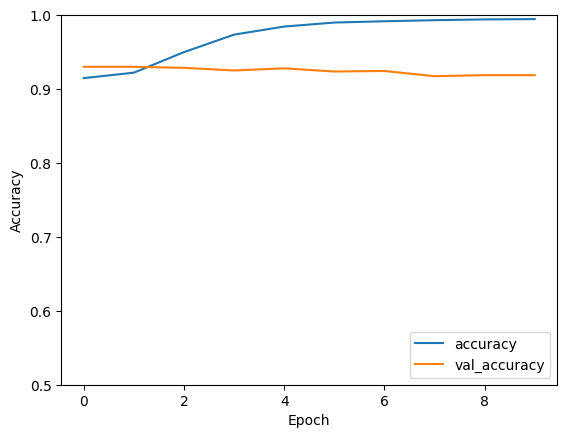

========== Test Evaluation ==========
86/86 - 0s - loss: 9.9099 - accuracy: 0.0015 - 322ms/epoch - 4ms/step
Test loss: 9.909931182861328 | Test accuracy: 0.0014593214727938175

========== Test Metrics ==========
86/86 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.16      0.02      0.03       240
           1       0.00      0.00      0.00      2501
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.00      2741
   macro avg       0.04      0.00      0.01      2741
weighted avg       0.01      0.00      0.00      2741



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
EvaluateModel(naive_model, test_encoded_padded, test_df['sender_labels'], naive_history)

# Naive LSTM

In [24]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = 5,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 64,
        hidden_size = 64,
        learning_rate: float = 0.001,
    ):

    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dense(hidden_size),
        keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [25]:
naive_lstm_model = create_naive_lstm_model(embedding_output=128)
naive_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 294, 128)          640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 747332 (2.85 MB)
Trainable params: 747332 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)     

In [26]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    train_df["label_encoded"], 
    validation_data=(validation_encoded_padded,validation_df['label_encoded']), 
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 31s 66ms/step - loss: 0.3753 - accuracy: 0.9155 - val_loss: 0.3073 - val_accuracy: 0.9301
Epoch 2/10
411/411 [==============================] - 18s 43ms/step - loss: 0.3214 - accuracy: 0.9170 - val_loss: 0.3306 - val_accuracy: 0.9301
Epoch 3/10
411/411 [==============================] - 16s 40ms/step - loss: 0.2607 - accuracy: 0.9231 - val_loss: 0.3863 - val_accuracy: 0.9258
Epoch 4/10
411/411 [==============================] - 16s 40ms/step - loss: 0.1969 - accuracy: 0.9397 - val_loss: 0.5020 - val_accuracy: 0.8912
Epoch 5/10
411/411 [==============================] - 18s 44ms/step - loss: 0.1469 - accuracy: 0.9535 - val_loss: 0.5420 - val_accuracy: 0.8969
Epoch 6/10
411/411 [==============================] - 16s 40ms/step - loss: 0.1097 - accuracy: 0.9645 - val_loss: 0.5745 - val_accuracy: 0.8955
Epoch 7/10
411/411 [==============================] - 16s 40ms/step - loss: 0.0834 - accuracy: 0.9726 - val_loss: 0.7127 - val_accuracy:

========== Model Accuracy ==========


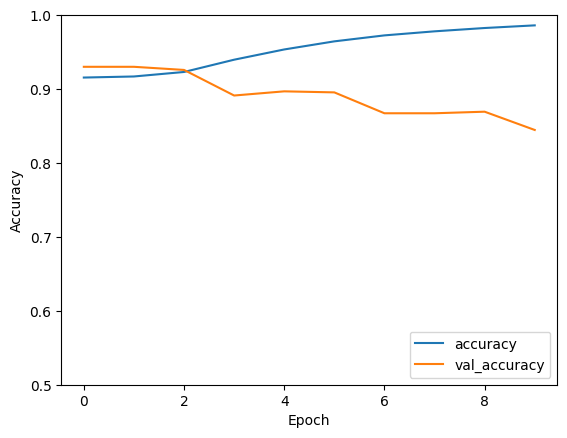

========== Test Evaluation ==========
86/86 - 2s - loss: 1.5830 - accuracy: 0.8107 - 2s/epoch - 18ms/step
Test loss: 1.5830214023590088 | Test accuracy: 0.810653030872345

========== Test Metrics ==========
86/86 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.04      0.04      0.04       123
           1       0.00      0.00      0.00        42
           2       0.16      0.09      0.11       198
           3       0.88      0.93      0.90      2378

    accuracy                           0.81      2741
   macro avg       0.27      0.26      0.26      2741
weighted avg       0.77      0.81      0.79      2741



In [27]:
EvaluateModel(naive_lstm_model, test_encoded_padded, test_df['label_encoded'], naive_lstm_history)

<hr/>

# Context lstm

In [28]:
def create_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = 5,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 64,
        hidden_size = 64,
        learning_rate: float = 0.001,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(0.2)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(0.2)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
        keras.layers.Dense(4, activation='softmax')
    )

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=context_lstm_ouput
    )

    context_lstm_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return context_lstm_model

In [29]:
context_lstm_model = create_lstm_model(
    embedding_output=128
)
context_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_2 (Embedding)     (None, 294, 128)             640000    ['current_message_input[0][0]'
                                                                    ]                         

In [30]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    train_df["label_encoded"], 
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded],validation_df['label_encoded']), 
    epochs=10
)

Epoch 1/10
411/411 [==============================] - 36s 76ms/step - loss: 0.3837 - accuracy: 0.9148 - val_loss: 0.3171 - val_accuracy: 0.9301
Epoch 2/10
411/411 [==============================] - 20s 50ms/step - loss: 0.3046 - accuracy: 0.9181 - val_loss: 0.3546 - val_accuracy: 0.9287
Epoch 3/10
411/411 [==============================] - 18s 44ms/step - loss: 0.2139 - accuracy: 0.9322 - val_loss: 0.4664 - val_accuracy: 0.9153
Epoch 4/10
411/411 [==============================] - 18s 45ms/step - loss: 0.1218 - accuracy: 0.9603 - val_loss: 0.5891 - val_accuracy: 0.8799
Epoch 5/10
411/411 [==============================] - 17s 41ms/step - loss: 0.0631 - accuracy: 0.9807 - val_loss: 0.8034 - val_accuracy: 0.8785
Epoch 6/10
411/411 [==============================] - 17s 42ms/step - loss: 0.0375 - accuracy: 0.9879 - val_loss: 0.9986 - val_accuracy: 0.8722
Epoch 7/10
411/411 [==============================] - 17s 41ms/step - loss: 0.0256 - accuracy: 0.9910 - val_loss: 1.2053 - val_accuracy:

========== Model Accuracy ==========


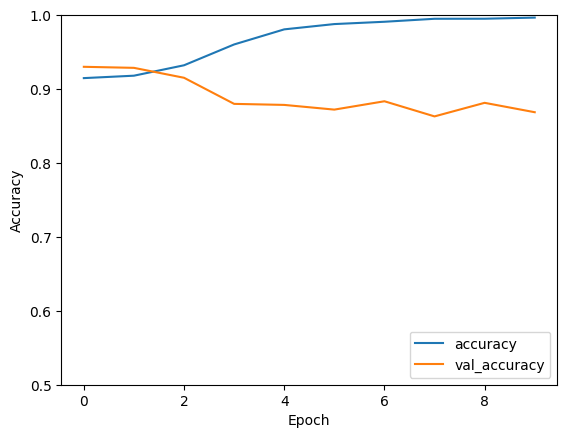

========== Test Evaluation ==========
86/86 - 2s - loss: 2.1748 - accuracy: 0.8249 - 2s/epoch - 22ms/step
Test loss: 2.1748239994049072 | Test accuracy: 0.8248814344406128

========== Test Metrics ==========
86/86 [==============================] - 2s 16ms/step
                 precision    recall  f1-score   support

      cassandra       0.07      0.05      0.06       123
         caught       0.60      0.07      0.13        42
        deceive       0.12      0.05      0.07       198
straightforward       0.87      0.94      0.91      2378

       accuracy                           0.82      2741
      macro avg       0.42      0.28      0.29      2741
   weighted avg       0.78      0.82      0.80      2741



In [31]:
EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], test_df['label_encoded'], context_lstm_history, label_encoder)